In [1]:

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from dynamical_systems.continuous import Lorenz96
from dynamics_discovery.preprocessing import standardize


jax.config.update("jax_enable_x64", True)
plt.style.use("matplotlib_utils.styles.dash_gridded")

In [32]:
lorenz = Lorenz96()
dt = 0.01
t = jnp.arange(10000) * dt

seed = 0
u0 = jax.random.normal(jax.random.PRNGKey(seed), shape=(2, lorenz.dim))
u0.shape
u = jax.vmap(lambda u0_: lorenz.solve(jnp.asarray([0, 1000]), u0_, max_steps=None))(u0)
u = jax.vmap(lambda u0_: lorenz.solve(1000 + t, u0_, max_steps=None))(u[:, 1])


In [33]:
u_train = standardize(u[0])
u_train.shape

(10000, 20)

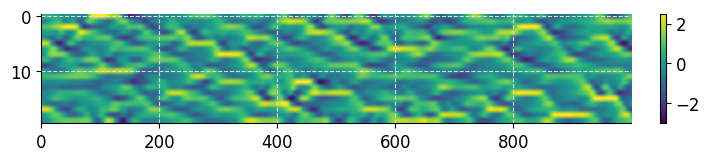

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(7, 1.5))
im = ax.imshow(u_train[:1000].T, aspect="auto", vmin=-3, vmax=2.5)
fig.colorbar(im, ax=ax)

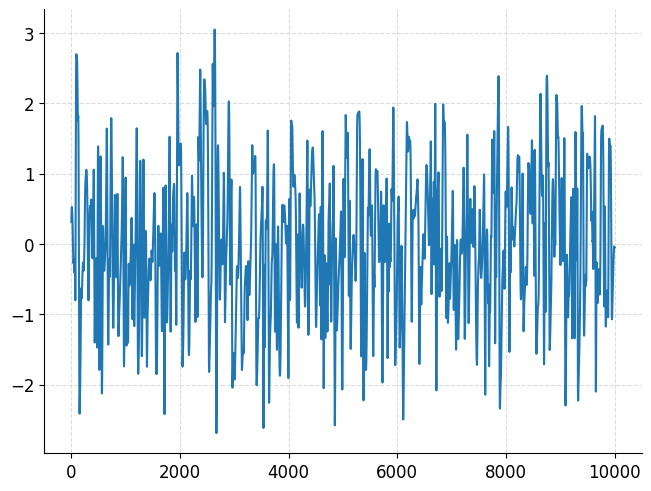

In [36]:
plt.plot(u_train[:, 0])